# Create vectors DB

In [1]:
import os
import shutil
from pathlib import Path
from langchain_ollama import OllamaEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain_chroma import Chroma

In [2]:
def remove_chroma_directory(directory: str) -> None:
    """Remove the existing Chroma directory if it exists."""
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Removed existing Chroma directory: {directory}")
    else:
        print(f"No existing Chroma directory found at: {directory}")

In [3]:
def get_embedding_model(model_name: str = "llama3.2"):
    """Get an embedding model. Default: Ollama Embeddings."""
    print(f"Loading embedding model: {model_name}")
    return OllamaEmbeddings(model=model_name)

In [4]:
from langchain_community.document_loaders import PyPDFLoader

def load_documents(docs_path: str, exclude_patterns=None) -> list:
    if exclude_patterns is None:
        exclude_patterns = [".DS_Store", ".ipynb_checkpoints"]

    base_path = Path(docs_path)
    all_files = base_path.rglob("*")

    documents = []
    for file in all_files:
        if not file.is_file():
            continue

        if any(file.match(pattern) for pattern in exclude_patterns):
            continue

        # Decide loader by extension
        if file.suffix.lower() == ".pdf":
            print(f"Loading PDF: {file}")
            loader = PyPDFLoader(str(file.absolute()))
        else:
            print(f"Loading text: {file}")
            # Fallback to TextLoader
            loader = TextLoader(str(file.absolute()), encoding='utf-8')

        documents.extend(loader.load())

    print(f"Total documents loaded: {len(documents)}")
    return documents


In [5]:
def build_vectorstore(docs: list, embeddings, persist_dir: str, collection: str):
    """Build and persist a Chroma vectorstore from documents."""
    db = Chroma.from_documents(
        documents=docs,
        embedding=embeddings,
        persist_directory=persist_dir,
        collection_name=collection
    )
    print(f"Chroma DB persisted at: {persist_dir}")
    return db

In [6]:
def main():
    # 1) Remove old Chroma data
    remove_chroma_directory('./chroma')

    # 2) Get embedding model
    embedding_llm = get_embedding_model("llama3.2")

    # 3) Load documents
    documents = load_documents("./data")

    # 4) Build and persist vectorstore
    db = build_vectorstore(
        docs=documents,
        embeddings=embedding_llm,
        persist_dir="./chroma",
        collection="vermac-support"
    )


if __name__ == "__main__":
    main()

No existing Chroma directory found at: ./chroma
Loading embedding model: llama3.2
Loading PDF: data\products\bpcms-1500-pro-series-product-sheet-ver-mac-003.pdf
Loading text: data\products\pcms.txt
Total documents loaded: 3
Chroma DB persisted at: ./chroma


# Retrieval

In [7]:
import os
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
from langchain.tools.retriever import create_retriever_tool
from langchain.prompts import (
    SystemMessagePromptTemplate,
    MessagesPlaceholder,
    HumanMessagePromptTemplate,
    PromptTemplate
)

In [8]:
def get_embedding_model(model_name: str = "llama3.2"):
    """
    Returns the chosen embedding model (Ollama or OpenAI).
    Default is OllamaEmbeddings set to llama3.2.
    """
    # Uncomment this block if you want to use OpenAI Embeddings:
    # with open('./openai_api_key.txt') as f:
    #     openai_api_key = f.read()
    # return OpenAIEmbeddings(openai_api_key=openai_api_key)

    print(f"Loading embedding model: {model_name}")
    return OllamaEmbeddings(model=model_name)

In [9]:
def load_chroma_db(embedding_llm, persist_directory: str, collection_name: str):
    """
    Loads a Chroma vector store with the given embedding function.
    """
    print(f"Loading Chroma DB from: {persist_directory}, collection: {collection_name}")
    db = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding_llm,
        collection_name=collection_name
    )
    return db

In [10]:
def similarity_search_examples(db, query: str):
    """
    Demonstrates similarity search operations on the given Chroma DB.
    """
    # Basic similarity search
    print(f"\n=== Basic Similarity Search with Query: '{query}' ===")
    results_with_scores = db.similarity_search_with_relevance_scores(query)
    print(f"Number of results: {len(results_with_scores)}")
    print("Results:", results_with_scores)

    # Limit to top K results
    k = 2
    print(f"\n=== Top {k} Similarity Search ===")
    top_k_results = db.similarity_search_with_relevance_scores(query, k=k)
    print(f"Number of results: {len(top_k_results)}")
    print("Results:", top_k_results)

    # MMR
    print("\n=== MMR (Maximum Marginal Relevance) ===")
    mmr_results = db.max_marginal_relevance_search(query, k=k)
    print(f"MMR results, k={k}:", mmr_results)

In [11]:
def retriever_examples(db, query: str):
    """
    Demonstrates usage of a retriever for the given Chroma DB.
    """
    print("\n=== Retriever Example ===")
    retriever = db.as_retriever(search_type='mmr', search_kwargs={'k': 2, 'fetch_k': 5})
    retrieved_docs = retriever.invoke(query)
    print("Retrieved docs:", retrieved_docs)

In [12]:
def main():
    # 1. Get Embeddings
    embedding_llm = get_embedding_model("llama3.2")

    # 2. Load Chroma DB
    db = load_chroma_db(
        embedding_llm=embedding_llm,
        persist_directory="./chroma",
        collection_name="vermac-support"
    )

    # 3. Perform similarity search operations
    query = "PCMS"
    similarity_search_examples(db, query)

    # 4. Demonstrate retriever usage
    retriever_examples(db, query)


if __name__ == "__main__":
    main()

Loading embedding model: llama3.2
Loading Chroma DB from: ./chroma, collection: vermac-support

=== Basic Similarity Search with Query: 'PCMS' ===


Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
C:\Users\porka\AppData\Local\Temp\ipykernel_27420\2230615496.py:7: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'source': 'c:\\Users\\porka\\Desktop\\CHATBOT\\support-chatbot\\app\\data\\products\\pcms.txt'}, page_content="Portable Changeable Message Signs\n\nRely on our portable changeable message signs (PCMSs) to communicate your messages simply and effectively. Available in different sizes, with three-line or full-matrix displays,\n they are designed for all types of work zones. Energy-efficient, robust, and connected, they offer an excellent ROI.\n\nDesigned to Meet Your Needs:\n\nMaintaining your portable changeable message signs is costing you time and money?\nRugged, durable, and reliable, Ver-Mac’s PCMSs require very little maintenance.\n\nIs it complicated to configure and use your PCMSs? Does managing them in the work zone put your workers at 

Number of results: 3
Results: [(Document(metadata={'source': 'c:\\Users\\porka\\Desktop\\CHATBOT\\support-chatbot\\app\\data\\products\\pcms.txt'}, page_content="Portable Changeable Message Signs\n\nRely on our portable changeable message signs (PCMSs) to communicate your messages simply and effectively. Available in different sizes, with three-line or full-matrix displays,\n they are designed for all types of work zones. Energy-efficient, robust, and connected, they offer an excellent ROI.\n\nDesigned to Meet Your Needs:\n\nMaintaining your portable changeable message signs is costing you time and money?\nRugged, durable, and reliable, Ver-Mac’s PCMSs require very little maintenance.\n\nIs it complicated to configure and use your PCMSs? Does managing them in the work zone put your workers at risk? \nOur portable changeable message signs can be managed easily, safely and remotely with our JamLogic software. \n\nDo the batteries on your PCMSs keep getting stolen?\nEnjoy peace of mind wi

# Agent

In [13]:
import os
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
from langchain.tools.retriever import create_retriever_tool
from langchain.prompts import SystemMessagePromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate, PromptTemplate
from langchain_ollama.chat_models import ChatOllama
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import gradio as gr

In [14]:
def get_ollama_embedding_llm(model_name: str = "llama3.2"):
    """
    Returns the Ollama embeddings model (default = 'llama3.2').
    """
    print(f"Loading Ollama Embeddings: {model_name}")
    return OllamaEmbeddings(model=model_name)

In [15]:
def load_chroma_db(collection_name: str = "planetbucks", persist_dir: str = "./chroma"):
    """
    Loads the Chroma database with the given collection name and persist directory.
    """
    embedding_llm = get_ollama_embedding_llm()
    print(f"Loading Chroma DB from '{persist_dir}' with collection '{collection_name}'")
    db = Chroma(persist_directory=persist_dir, embedding_function=embedding_llm, collection_name=collection_name)
    return db

In [16]:
def create_planetbucks_retriever(db):
    """
    Creates a retriever tool for PlanetBucks.
    """
    description = """Search for information about PlanetBucks store, including store information, 
    coffee drink menus, specialty coffee beans menu, and bean fact sheet."""
    retriever = db.as_retriever(search_type='mmr')
    retriever_tool = create_retriever_tool(
        retriever, 
        name="planetbucks_search", 
        description=description
    )
    return retriever_tool

In [24]:
def build_langgraph_agent(tools, system_message: str):
    """
    Builds a LangGraph agent executor with the given list of tools and system message.
    """
    llm = ChatOllama(model="llama3.2", temperature=0)
    memory = MemorySaver()

    # Create the agent
    agent_executor = create_react_agent(
        llm,
        tools=tools,
        state_modifier=system_message,
        checkpointer=memory
    )
    return agent_executor, memory

In [18]:
def show_langgraph_graph(agent_executor):
    """
    Displays the agent's graph as a PNG image in the notebook.
    """
    graph_data = agent_executor.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
    display(Image(graph_data))

In [19]:
def run_agent_example(agent_executor, query: str, config=None):
    """
    Example invocation of the agent with a query.
    """
    if config is None:
        config = {"configurable": {"thread_id": "thread1"}}

    response = agent_executor.invoke({"messages": [("human", query)]}, config)
    return response

In [20]:
def run_gradio_chat_interface(agent_executor, config=None):
    """
    Launches a Gradio ChatInterface for interacting with the agent.
    """

    if config is None:
        config = {"configurable": {"thread_id": "thread1"}}

    def chat(message, history):
        # We can read the 'history' if we want to store or parse it externally
        response = agent_executor.invoke({"messages": [("human", message)]}, config)
        return response['messages'][-1].content

    # (Re)Launch only if it hasn't been launched
    try:
        demo.close()
    except NameError:
        pass
    except:
        pass

    demo = gr.ChatInterface(fn=chat)
    demo.launch(share=False)
    return demo

Loading Ollama Embeddings: llama3.2
Loading Chroma DB from './chroma' with collection 'vermac-support'


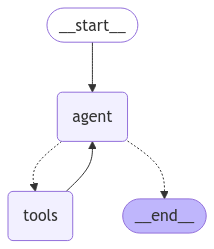

Number of requested results 20 is greater than number of elements in index 3, updating n_results = 3



--- Agent Example Response ---
Here is a summary of the PCMS-1500 trailer-mounted message sign:

**Key Features:**

1. **Full-matrix display**: 131 x 75 in. (3331 x 1917 mm) display panel with 28 x 48 pixels, 4 LEDs per pixel.
2. **Energy-efficient design**: Solar panels provide maximum solar recharging year-round, and the unit is designed to run 12 months without manual charging.
3. **High-quality construction**: Superb powder coating finish, impact-resistant, humidity-resistant, and rust-resistant.
4. **Stealth Technology**: Maintenance-free batteries with anti-theft hidden battery compartment.
5. **V-Sync Wi-Fi technology**: Change messages safely using a smartphone app.
6. **JamLogic Fleet Management Software**: Hourly automated status and battery/GPS alerts & reports, interactive map & list view of all equipment, project folders to organize equipment, and logs date/time of all remotely activated messages.

**Operating Characteristics:**

1. **Dimensions and weight**: Operating he

C:\Users\porka\AppData\Roaming\Python\Python312\site-packages\gradio\components\chatbot.py:255: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Number of requested results 20 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 20 is greater than number of elements in index 3, updating n_results = 3


In [25]:
def main():
    # 1) Load Chroma DB and create tools
    db = load_chroma_db("vermac-support", "./chroma")
    retriever_tool = create_planetbucks_retriever(db)

    # 2) Create the agent executor
    SYSTEM_MESSAGE = """You are a helpful receptionist at Vermac. Your name is Keven.
You will answer politely and professionaly."""
    agent_executor, memory = build_langgraph_agent([retriever_tool], SYSTEM_MESSAGE)

    # (Optional) Show the agent graph
    show_langgraph_graph(agent_executor)

    # 3) Basic example usage in Python (not Gradio)
    example_query = "What is a PCMS ?"
    response = run_agent_example(agent_executor, example_query)
    print("\n--- Agent Example Response ---")
    print(response['messages'][-1].content)

    # 4) Launch a Gradio ChatInterface
    print("\n--- Launching Gradio ChatInterface ---")
    run_gradio_chat_interface(agent_executor)


if __name__ == "__main__":
    main()